In [1]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive")
%cd "/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/"

# Folder with dataset time data csv's
folder = '/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition


# Initialisation


In [2]:
import sys
import os
# sys.path.append('/Users/Joe/opt/anaconda3/lib/python3.8/site-packages/ffmpeg')
import math
import sklearn
from sklearn.preprocessing import LabelEncoder, normalize
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM, Add, Bidirectional, SpatialDropout2D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Reshape, LeakyReLU, Bidirectional
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D 
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.utils import to_categorical
import seaborn as sb
!pip install json_tricks
from json_tricks import dump, load

rs = 87

folder = "Features/TIME"
# -----------------------

# API

## Feature Extraction

In [3]:

def melspec_img(path, measurement, feature ,fs, Nfft, hop_length, win_length, chunksize =100, fmax = 8000,
               n_mels = 128):
    labels = []
    features =[]


    i = 0
    
    for chunk in pd.read_csv(path, chunksize=chunksize):
        x_chunk = chunk.iloc[:, 8:] 
        
        j = 0
        while j < len(chunk.index):
            x = np.array(x_chunk)
            y = chunk[measurement]
            y = np.asarray(y)
            temp = x[j]
            np.nan_to_num(temp, nan=0)
            fig = plt.figure(figsize=(10,3))
              
            # if np.isnan(signal).any() == True:
            #   print(f"WARNING: Nan detected {i}")
            mels = librosa.feature.melspectrogram(temp, sr = fs, n_fft = Nfft, 
                                                    hop_length = hop_len, 
                                                    win_length = win_len, n_mels = 128,
                                                    window = 'hann', fmax = 8000)
            
            dbX = librosa.power_to_db(mels, ref = np.max)
            img = librosa.display.specshow(dbX, sr = fs, y_axis = 'mel', 
                                            x_axis = 'time', fmax = 8000, 
                                            hop_length=hop_len)
            plt.ylim(0, 8000)
              
            actor = chunk['Actor ID']  
            actor = np.asarray(actor)
            actor_id = actor[j]
            # print(actor_id)
            filename_img = f"{y[j]}"

            save_loc = f"{out_path}/{dataset}/{feature}/{filename_img}_{feature}_{actor_id}_{i}.png"
            if not os.path.exists(f"{out_path}/{dataset}/{feature}/"):
                os.makedirs(f"{out_path}/{dataset}/{feature}/")
            plt.axis('off')
            plt.Axes(fig, [0,0,1,1])
            
            plt.savefig(save_loc)
            plt.close()
  
            j = j+1
            i = i+1

## Architecture



In [4]:
def id_block(X, f, filters, s=1, dr=1, dropout=0.5):
  F1, F2, F3 = filters

  X_skip = X

  X = Conv2D(F1, (f,f), padding='same', strides=(s,s) ,dilation_rate=dr)(X_skip)
  X = SpatialDropout2D(dropout)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)

  X = Conv2D(F2, (f,f), padding='same', strides=(s,s) ,dilation_rate=dr)(X)
  X = SpatialDropout2D(dropout)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)

  X = Conv2D(F3, (f,f), padding='same', strides=(s,s) ,dilation_rate=dr)(X)
  X = SpatialDropout2D(dropout)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)

  X = Add()([X, X_skip])
  X = LeakyReLU(alpha=0.2)(X)

  return X

def conv_block(X, f, filters, s=1, dr=1, dropout=0.5):
  F1, F2, F3 = filters

  X_skip = X

  X = Conv2D(F1, (f,f), padding='same', strides=(s,s) ,dilation_rate=dr)(X_skip)
  X = SpatialDropout2D(dropout)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)

  X = Conv2D(F2, (f,f), padding='same', strides=(s,s) ,dilation_rate=dr)(X)
  X = SpatialDropout2D(dropout)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)
 
  X = Conv2D(F3, (f,f), padding='same', strides=(s,s) ,dilation_rate=dr)(X)
  X = SpatialDropout2D(dropout)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.2)(X)

  X_skip = Conv2D(F1, (f,f), padding='same', strides=(s,s) ,dilation_rate=dr)(X_skip)
  X = SpatialDropout2D(dropout)(X)
  X_skip = BatchNormalization()(X_skip)
  X = Add()([X, X_skip])
  X = LeakyReLU(alpha=0.2)(X)

  return X

# Feature Extraction

## Set Params

In [5]:

fs = 16000

# Setting FFT params
Nfft = 512        # FFT Length
win_len_ms = 25   # Window Length in ms
hop_len_ms = 10   # Hop Size in ms

# Converting ms to samples
win_len = int((fs/1000) * win_len_ms)
hop_len = int((fs/1000) * hop_len_ms)

# Serialising params
dataset ='CREMA'
sr = str(fs)
# fts1 = 'Shifted_Noisey'
feature = "Shifted_Noisey"
feature_save_name = f"/{feature}_{dataset}_{sr}"
load_path = f"{folder}Features/TIME/{dataset}/{feature_save_name}.csv" 

# Creating path for X and y feature data tobe saved

out_path = f"{os.getcwd()}/Features/MELSPEC-IMG/"
if not os.path.exists(out_path):
    os.makedirs(out_path)




## Load Images

In [6]:
# r = pd.read_csv(load_path)
# print(r.dtypes)
# print(type(r.features[1]))

# r.features.isna().sum()

In [7]:
# # Serialising params
# sr = str(fs)
# feature = "Clean"
# feature_save_name = f"/{feature}_{dataset}_{sr}"
# load_path = f"{os.getcwd()}/{folder}/{dataset}{feature_save_name}.csv" 

# melspec_img(load_path,"Labels",feature, fs ,Nfft,hop_len, win_len, 200, 8000, 128)


In [8]:
# # Serialising params
# sr = str(fs)
# feature = "Shifted_Noisey"
# feature_save_name = f"/{feature}_{dataset}_{sr}"
# load_path = f"{os.getcwd()}/{folder}/{dataset}{feature_save_name}.csv" 

# melspec_img(load_path,"Labels",feature, fs ,Nfft,hop_len, win_len, 200, 8000, 128)
# print(f"All images saved in: \n {out_path}")

# Create Dataset

## Check images

/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/Features/MELSPEC-IMG/
(216, 720, 4)
(216, 720, 4)
(216, 720, 4)
(216, 720, 4)
(216, 720, 4)


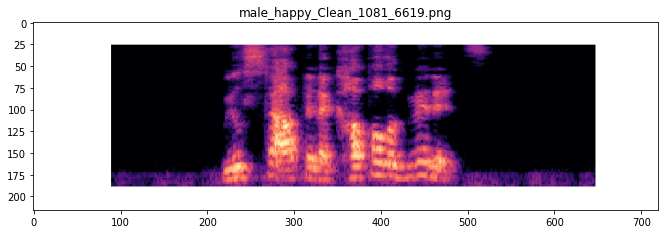

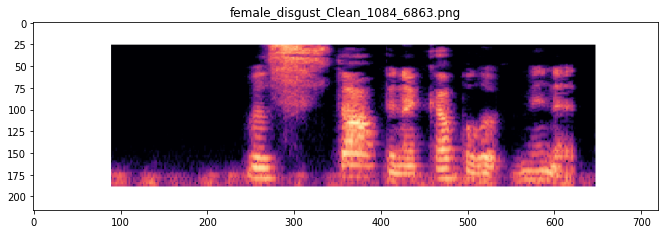

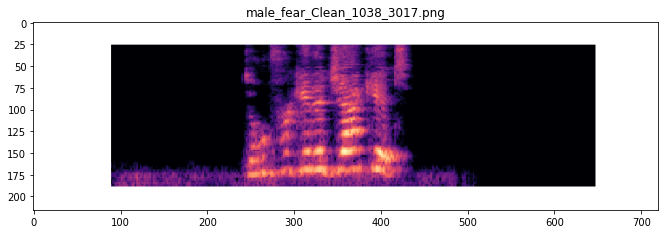

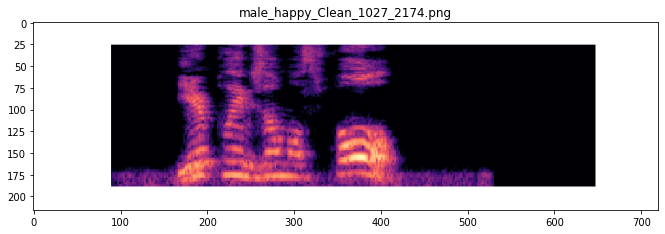

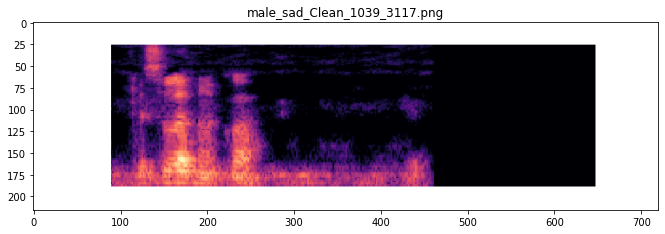

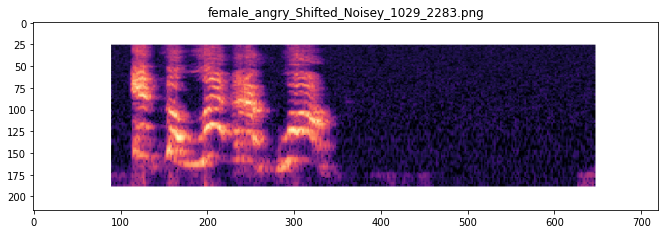

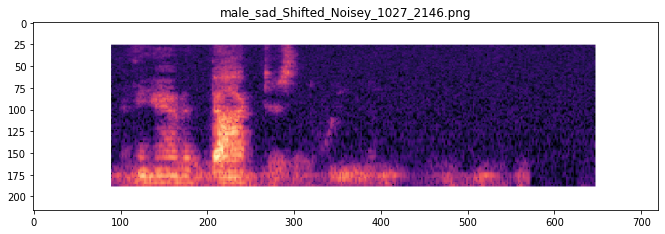

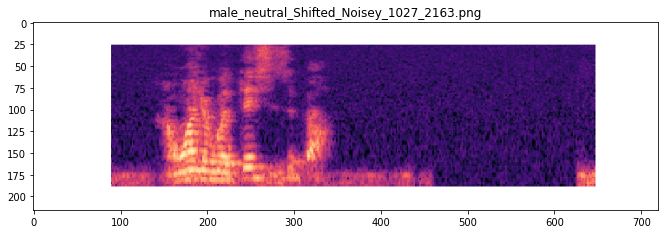

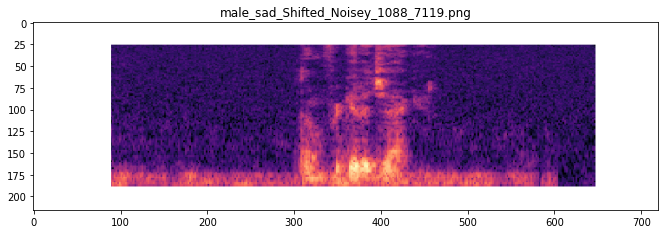

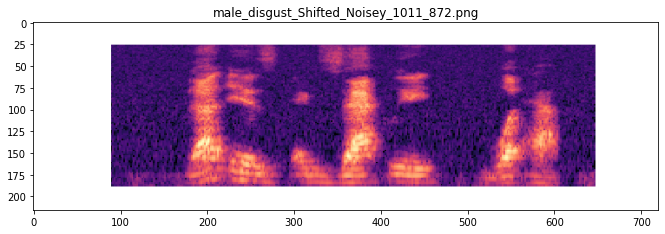

<Figure size 1440x1440 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,20))
img_folder=f"{out_path}{dataset}/Clean/"
print(out_path)
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    plt.axis('off')
    ax=plt.subplot(5,1,i+1)
    ax.title.set_text(file)
    plt.imshow(img)
    plt.figure(figsize=(20,20))

img_folder=f"{out_path}{dataset}/Shifted_Noisey/"
for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    plt.axis('off')
    ax=plt.subplot(5,1,i+1,)
    ax.title.set_text(file)
    plt.imshow(img)
    plt.figure(figsize=(20,20))
    print(img.shape)

## Load feature arrays and labels

Load Train Data

In [ ]:
X=[]
y=[]
test_X =[]
test_y = []
IMG_WIDTH=200
IMG_HEIGHT=300
actors =[1,2]

load_dir = f"{out_path}{dataset}/Clean/"
for file in os.listdir(load_dir):  

    temp1 = file.split('_')[0]
    temp2 = file.split('_')[1]
    temp3 = file.split('_')[3]
    
    image_path= os.path.join(load_dir, file)
    image = cv2.imread( image_path, cv2.COLOR_RGB2BGR)
    try:
           image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    except:
        break
        image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),
                          interpolation = cv2.INTER_AREA)
        image = np.array(image)
        image = image.astype('float64')
        image /= 255 
## -------------------------------
## Splitting dataset for speaker independence testing 
## -------------------------------
    

    if temp3 == '1' or temp3 =='2':
      test_X.append(image)
      test_y.append((f"{temp1}_{temp2}_{temp3}_Clean"))
    else:
      X.append(image)
      y.append(f"{temp1}_{temp2}_{temp3}_Clean")
      

    

load_dir = f"{out_path}{dataset}/Shifted_Noisey/"

for file in os.listdir(load_dir):
    temp1 = file.split('_')[0]
    temp2 = file.split('_')[1]
    temp3 = file.split('_')[4]
    image_path= os.path.join(load_dir, file)
    image = cv2.imread( image_path, cv2.COLOR_RGB2BGR)
    try:
           image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), 
                              interpolation = cv2.INTER_AREA)
                       
    except:
        
      image = np.array(image)
      image = image.astype('float64')
      image /= 255 
    

## -------------------------------
## Splitting dataset for speaeker independence testing 
## -------------------------------
    if temp3 == '1' or temp3 =='2':
      test_X.append(image)
      test_y.append(f"{temp1}_{temp2}_{temp3}_Aug")
    else:
      X.append(image)
      y.append(f"{temp1}_{temp2}_{temp3}_Aug")

    

# X = np.asarray(X).astype('float')
# y = np.asarray(y)
# X = X[0:100]
# y = y[0:100]
# print(f"Shape of feature arrays: {X.shape}\n")
# print(f"Shape of label arrays: {y.shape}\n")

print(y)



print(test_y)


# Prepare Data

In [ ]:
X_si_test = np.asarray(test_X)
y_si_test = np.asarray(test_y)

X = np.asarray(X)
y = np.asarray(y)

print(f"Shape of feature arrays: {X.shape}\n")
print(f"Shape of label arrays: {y.shape}\n")

(unique, counts) = np.unique(y, return_counts=True)
freq = np.asarray((unique,counts)).T
print('Label Counts:\n\n', freq)

## Seperate speaker independence test

## Normalise

In [ ]:
def normalise(X):
    mean = np.mean(X, axis = 0)
    std = np.std(X, axis = 0)
    X = (X - mean) / std
    X = np.nan_to_num(X)
    return X

X = normalise(X)
X_si_test = normalise(X_si_test)
print(y.shape)

## Split data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=True, stratify=y, random_state=rs)

# X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7, shuffle=True, stratify=y, random_state=rs)
# X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, shuffle = True, stratify=y_rem, random_state=rs)

print(f"Train Size = {len(X_train)}")
print(f"Val Size = {len(X_val)}")
print(f"Test Size = {len(X_si_test)}")

def labler(y):
    y = pd.DataFrame(y, columns=['Tags'])
    y = y['Tags'].str.split('_').str[1]

    y = np.asarray(y)
    return y
y_train = labler(y_train)
y_val = labler(y_val)
y_si_test = labler(y_si_test)



## Encode labels

In [ ]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_val = to_categorical(lb.transform(y_val))
y_si_test = to_categorical(lb.transform(y_si_test))

# Model


## 2D CNN

### Params

In [ ]:
model_name = 'CNN_IMG_RAV_2'
model_name_save = model_name + '_weights'+'.h5'

num_fc = 64
batch_size = 16
num_classes = 6
num_epochs = 500 #best model will be saved before number of epochs reach this value
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9
input_shape = X_train.shape[1:4]
print(X_train.shape)

### Callbacks

In [ ]:
%%time

# Save best weights
cp_path = "/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/saved_models/Best_" + model_name_save
mcp_save = callbacks.ModelCheckpoint(cp_path)


# Reduce learning rate and stopping
reduce_LR = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=30)


### Architecture

In [ ]:

def resnet1(input_shape = input_shape, model_name = model_name):

  X_input = Input(input_shape)
  X_input = SpatialDropout2D(0.7)(X_input)

  X = Conv2D(16, (3,3), padding='same', input_shape = input_shape)(X_input)
  X = SpatialDropout2D(0.7)(X)
  X = BatchNormalization()(X)
  X = LeakyReLU()(X)
  X = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(X)

  X = conv_block(X, f=3, filters=[16,16,16], dropout=0.6)
  X = conv_block(X, f=3, filters=[32,32,32], dropout=0.6)
  X = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(X)

  X = conv_block(X, f=3, filters=[32,32,32], dropout=0.5)
  X = conv_block(X, f=3, filters=[64,64,64], dropout=0.5)
  X = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(X)

  X = conv_block(X, f=3, filters=[64,64,64], dropout=0.5)
  X = conv_block(X, f=3, filters=[128,128,128], dropout=0.5)
  X = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(X)


  X = LeakyReLU(alpha=0.2)(X)
  X = Reshape((128,-1))(X)
  X = Bidirectional(LSTM(512))(X)
  X = Dropout(0.7)(X)

  X = Dense(512)(X)
  X = Dropout(0.5)(X)
  X = Dense (256)(X)
  X = Dropout(0.5)(X)
  X = Flatten()(X)
  X = Dense(6) (X) # Target class number
  X = Activation('softmax')(X)

  model = Model(inputs = X_input, outputs = X, name = model_name)
  return model

model = resnet1()
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()





### Train

In [ ]:

model_history=model.fit(X_train, y_train, batch_size=batch_size, 
                        epochs=num_epochs, validation_data=(X_val, y_val),
                        callbacks=[reduce_LR, early_stop, mcp_save])

### Serialize

In [ ]:
name = model_name_save
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

model_json = model.to_json()
with open('saved_models/' + model_name, "w") as json_file:
    json_file.write(model_json)


### Reports

Load Model

In [ ]:
model_path = "/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/saved_models/"+model_name
weights_path = "/content/drive/MyDrive/Colaboratory/Speech Emotion Recognition/saved_models/Best_"+ model_name_save

json_model = open(model_path, 'r')
loaded_model = json_model.read()
json_model.close()
loaded_model = model_from_json(loaded_model)
loaded_model.load_weights(weights_path)

Accuracy and Loss

In [ ]:
save_report = f"/content/drive/MyDrive/Colaboratory/SERv2/REPORTS/{model_name}/"
if not os.path.isdir(save_report):
    os.makedirs(save_report)

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title(model_name + ' Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0)
plt.ylim(0, 3)
plt.legend(['train', 'test'], loc='upper left')
save_name = f"{save_report}Model Training Loss.png"
plt.savefig(save_name)

plt.show()


plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title(model_name + ' Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(0)
plt.ylim(0,1)
plt.legend(['train', 'test'], loc='upper left')
save_name = f"{save_report}Model Training Accuracy.png"
plt.savefig(save_name)



In [ ]:
model.summary()
save_report = f"{os.getcwd()}/REPORTS/{model_name}/"
if not os.path.isdir(save_report):
    os.makedirs(save_report)
with open(f"{save_report} Summary.txt", 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))



Classification Results

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

loaded_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

def get_results(model, X_test, y_test, lb):
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    score = model.evaluate(X_test, y_test, verbose=0)
    accuracy = score[1]*100
    print(("Test Accuracy: ", model.metrics_names[1], score[1]*100))
    predictions = model.predict(X_test, batch_size=16, verbose=1)
    predictions = predictions.argmax(axis=1)
    predictions = predictions.astype(int).flatten()
    predictions = (lb.inverse_transform(predictions))
    predictions = pd.DataFrame({'predicted': predictions})

    actual = y_test.argmax(axis=1)
    actual = actual.astype(int).flatten()
    actual = (lb.inverse_transform(actual))
    actual = pd.DataFrame({'actual': actual})

    results = actual.join(predictions)
    
    return results, accuracy



In [ ]:
predictions, sd_acc = get_results(model = loaded_model, X_test = X_val, 
                      y_test = y_val, lb=lb)
# print(type(results))
def create_confusion_matrix(Y, save_path , model_name , 
           title):
  classes = Y.actual.unique()
  classes.tolist()
  classes.sort()
  cm = confusion_matrix(Y.actual, Y.predicted)
  cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cm_df = pd.DataFrame(cm_n, index=classes, columns=classes)
  fig = plt.figure(figsize=(9,8))
  try:
          heatmap = sb.heatmap(cm_df, annot=True)
  except ValueError:
      raise ValueError('Confusion matrix values must be ints')

  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
  plt.title(f"{model_name} {title}")
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  save_name = f"{save_report} {title}.png"
  plt.savefig(f"{save_report} {title}.png" )
  plt.show()

create_confusion_matrix(Y=predictions, save_path = save_report, model_name = model_name, 
           title=f"{model_name} Speaker Independent Results ")

classes = predictions.actual.unique()
classes.sort()
report = classification_report(predictions.actual, predictions.predicted, target_names=classes, output_dict=True, digits=3)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f"{save_report} model name Speaker Dependence Accuracy.csv")
report


In [ ]:
predictions, si_acc = get_results(model = loaded_model, X_test = X_si_test, 
                      y_test = y_si_test, lb=lb)
# print(type(results))
def create_confusion_matrix(Y, save_path , model_name , 
           title):
  classes = Y.actual.unique()
  classes.tolist()
  classes.sort()
  cm = confusion_matrix(Y.actual, Y.predicted)
  cm_n = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cm_df = pd.DataFrame(cm_n, index=classes, columns=classes)
  fig = plt.figure(figsize=(9,8))
  try:
          heatmap = sb.heatmap(cm_df, annot=True)
  except ValueError:
      raise ValueError('Confusion matrix values must be ints')

  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
  plt.title(f"{model_name} {title}")
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  save_name = f"{save_report} {title}.png"
  plt.savefig(f"{save_report} {title}.png" )
  plt.show()

create_confusion_matrix(Y=predictions, save_path = save_report, model_name = model_name, 
           title=f"{model_name} Speaker Independent Results ")


classes = predictions.actual.unique()
classes.sort()
report = classification_report(predictions.actual, predictions.predicted, target_names=classes, output_dict=True, digits=3)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f"{save_report} model name Speaker Indpendence Accuracy.csv")
report

### Testing on new dataset

Testing for robustness in speaker independency 

In [ ]:

from openpyxl import load_workbook

df = pd.DataFrame({'Name': [model_name],
                   'Speaker Dependent': [sd_acc], 
                   'Speaker Independent': [si_acc]})
writer = pd.ExcelWriter('SER_Model_Accuracy_MELSPEC-IMG.xlsx', engine='openpyxl')

# df.to_excel(writer, sheet_name='Sheet1', index=False)
# writer.save()

writer.book = load_workbook('SER_Model_Accuracy_MELSPEC-IMG.xlsx')
# copy existing sheets
writer.sheets = dict((ws.title, ws) for ws in writer.book.worksheets)
# read existing file
reader = pd.read_excel(r'SER_Model_Accuracy_MELSPEC-IMG.xlsx')
# write out the new sheet
df.to_excel(writer,index=False,header=False,startrow=len(reader)+1)
writer.close()
